In [7]:
import pandas as pd
df = pd.read_csv('yelp.csv')

In [8]:
df.head(5)

,rating,review
0,5,I used this app for the first time last Friday...
1,1,"Lost items, slow customer service (only availa..."
2,1,BEYOND TERRIBLE SERVICE. I'm not one to write ...
3,1,This was my first time using Cleanly. I decide...
4,1,Used cleanly again and they lost my entire bag...


In [9]:
import numpy as np
df['rating_type'] = np.where(df['rating']>=4, 'positive', 'negative')

positive=df[df['rating_type']=='positive']
positive.index = range(len(positive.index))
print(positive.shape)
positive=positive[['review']]

(443, 3)


In [10]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Convert to list
data = positive.review.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

['I used this app for the first time last Friday and requested to pick up the '
 'next day. At first I was very worried of what would happen because I have '
 'always gone to the laundromat... well,1) this saves so much time!2) '
 'everything was folded so nice!3) everything felt super soft!4) everything '
 'never looked so good!The pricing was very reasonable. Why would other people '
 'complain about the price when your paying for convenience?This was my first '
 'time using it and I cant wait to send my laundry again in another week!It '
 'saves you sitting in the laundry for 2 hours and also saves money on '
 'detergent and its delivered straight to your door!Download the app everyone! '
 'UPDATED REVIEW****Since my last review I have ordered it 3 times and they '
 'are still great! One day they picked this up at 8pm and it was back folded '
 'and clean in my hand at 8am the next day and I had a big heavy bag!Everyone '
 'should use this service! I no longer have to wait at the lau

In [11]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['used', 'this', 'app', 'for', 'the', 'first', 'time', 'last', 'friday', 'and', 'requested', 'to', 'pick', 'up', 'the', 'next_day', 'at', 'first', 'was', 'very', 'worried', 'of', 'what', 'would', 'happen', 'because', 'have', 'always', 'gone', 'to', 'the', 'laundromat', 'well', 'this', 'saves', 'so', 'much', 'time', 'everything', 'was', 'folded', 'so', 'nice', 'everything', 'felt', 'super', 'soft', 'everything', 'never', 'looked', 'so', 'good', 'the', 'pricing', 'was', 'very', 'reasonable', 'why', 'would', 'other', 'people', 'complain', 'about', 'the', 'price', 'when', 'your', 'paying', 'for', 'convenience', 'this', 'was', 'my', 'first', 'time', 'using', 'it', 'and', 'cant', 'wait', 'to', 'send', 'my', 'laundry', 'again', 'in', 'another', 'week', 'it', 'saves', 'you', 'sitting', 'in', 'the', 'laundry', 'for', 'hours', 'and', 'also', 'saves', 'money', 'on', 'detergent', 'and', 'its', 'delivered', 'straight', 'to', 'your', 'door', 'download', 'the', 'app', 'everyone', 'updated', 'review',

In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['use', 'app', 'first', 'time', 'last', 'friday', 'request', 'pick', 'next', 'day', 'first', 'worry', 'would', 'happen', 'always', 'go', 'laundromat', 'well', 'save', 'much', 'time', 'everything', 'fold', 'nice', 'everything', 'feel', 'super', 'soft', 'everything', 'never', 'look', 'good', 'pricing', 'reasonable', 'would', 'people', 'complain', 'price', 'pay', 'convenience', 'first', 'time', 'use', 'can', 'not', 'wait', 'send', 'laundry', 'week', 'save', 'sit', 'laundry', 'hour', 'also', 'save', 'money', 'detergent', 'deliver', 'straight', 'door', 'download', 'app', 'everyone', 'update', 'review', 'last', 'review', 'order', 'time', 'still', 'great', 'day', 'pick', 'pm', 'back', 'fold', 'clean', 'hand', 'next', 'day', 'big', 'heavy', 'bag', 'everyone', 'service', 'longer', 'wait', 'laundromat', 'even', 'spend', 'detergent']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 3), (18, 1), (19, 3), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 2), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 4), (60, 1), (61, 2), (62, 2), (63, 1), (64, 1), (65, 1), (66, 2)]]


In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"company" + 0.007*"give" + 0.006*"feel" + 0.006*"be" + 0.006*"new" + '
  '0.005*"chocolate" + 0.005*"fuzzy" + 0.005*"send" + 0.005*"warm" + '
  '0.005*"people"'),
 (1,
  '0.032*"cleanly" + 0.028*"laundry" + 0.026*"time" + 0.023*"clothe" + '
  '0.021*"always" + 0.019*"not" + 0.015*"back" + 0.015*"have" + 0.014*"fold" + '
  '0.013*"come"'),
 (2,
  '0.050*"service" + 0.023*"time" + 0.021*"laundry" + 0.019*"cleanly" + '
  '0.018*"clean" + 0.017*"great" + 0.015*"good" + 0.014*"app" + 0.013*"easy" + '
  '0.011*"customer"')]


In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.487351142678396

Coherence Score:  0.35434480508787375


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.111072 -0.097491       1        1  48.772285
2     -0.111526  0.097359       2        1  45.222618
0      0.222597  0.000132       3        1   6.005102, topic_info=     Category        Freq           Term       Total  loglift  logprob
52    Default  449.000000        service  449.000000  30.0000  30.0000
1     Default  181.000000         always  181.000000  29.0000  29.0000
80    Default   82.000000           give   82.000000  28.0000  28.0000
150   Default   20.000000        company   20.000000  27.0000  27.0000
153   Default   94.000000       customer   94.000000  26.0000  26.0000
51    Default   48.000000           send   48.000000  25.0000  25.0000
330   Default  133.000000             be  133.000000  24.0000  24.0000
18    Default   27.000000           feel   27.000000  23.0000  23.0000
430   Default   22.000000            new   22.000000  22.0000  22.0000
1308  Default   22.000000      chocolate   22.000000  21.0000  21.0000
45    Default   50.000000          price   50.000000  20.0000  20.0000
111   Default  113.000000           drop  113.000000  19.0000  19.0000
74    Default  243.000000         clothe  243.000000  18.0000  18.0000
40    Default   64.000000          order   64.000000  17.0000  17.0000
42    Default   62.000000         people   62.000000  16.0000  16.0000
197   Default   41.000000           take   41.000000  15.0000  15.0000
687   Default   34.000000            way   34.000000  14.0000  14.0000
126   Default   74.000000           make   74.000000  13.0000  13.0000
167   Default   19.000000           walk   19.000000  12.0000  12.0000
3     Default  158.000000           back  158.000000  11.0000  11.0000
22    Default   67.000000             go   67.000000  10.0000  10.0000
269   Default   19.000000           home   19.000000   9.0000   9.0000
277   Default   58.000000          thing   58.000000   8.0000   8.0000
404   Default   43.000000           lose   43.000000   7.0000   7.0000
173   Default   24.000000           city   24.000000   6.0000   6.0000
791   Default   21.000000            ask   21.000000   5.0000   5.0000
11    Default   44.000000        deliver   44.000000   4.0000   4.0000
38    Default   74.000000           nice   74.000000   3.0000   3.0000
162   Default   38.000000          place   38.000000   2.0000   2.0000
334   Default   97.000000         really   97.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
1075   Topic3    1.984545  unmentionable    2.710444   2.5008  -6.2335
546    Topic3    4.755257          photo    6.537384   2.4943  -5.3596
928    Topic3    3.441450       seamless    5.100831   2.4191  -5.6830
150    Topic3   10.733919        company   20.908918   2.1458  -4.5455
641    Topic3    3.965221          smile    6.440161   2.3276  -5.5413
1485   Topic3    2.272290         rarely    3.167970   2.4803  -6.0981
1123   Topic3    2.254594     eventually    3.185618   2.4669  -6.1059
969    Topic3    3.853483          write    7.036064   2.2105  -5.5699
1001   Topic3    4.463610        totally    9.700076   2.0364  -5.4229
1060   Topic3    2.632278      literally    4.315415   2.3182  -5.9510
430    Topic3    5.887187            new   22.812092   1.4580  -5.1461
18     Topic3    6.236422           feel   27.600718   1.3251  -5.0885
252    Topic3    3.341271            lug    7.687688   1.9793  -5.7125
1308   Topic3    5.329316      chocolate   22.606239   1.3676  -5.2457
1747   Topic3    3.046073      interface    6.455807   2.0614  -5.8050
269    Topic3    4.299910           home   19.402731   1.3057  -5.4603
80     Topic3    6.702785           give   82.261017   0.3052  -5.0164
301    Topic3    3.701345          night   15.139757   1.4039  -5.6102
51     Topic3    4.875517           send   48.402821   0.5172  -5.3347
197    Topic3    4.602172           take   41.067394   0.6239  -5.

In [19]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(0,
  [('good', 0.07608200455580866),
   ('delivery', 0.04874715261958998),
   ('make', 0.04100227790432802),
   ('thing', 0.03234624145785877),
   ('cleanly', 0.030979498861047835),
   ('work', 0.029612756264236904),
   ('day', 0.02642369020501139),
   ('send', 0.0255125284738041),
   ('hour', 0.021867881548974944),
   ('experience', 0.020045558086560365)]),
 (1,
  [('cleanly', 0.08552631578947369),
   ('laundry', 0.06710526315789474),
   ('clothe', 0.06315789473684211),
   ('bag', 0.046052631578947366),
   ('order', 0.03070175438596491),
   ('laundromat', 0.02763157894736842),
   ('valet', 0.02543859649122807),
   ('wash', 0.02456140350877193),
   ('people', 0.018421052631578946),
   ('place', 0.016666666666666666)]),
 (2,
  [('laundry', 0.12013455069678039),
   ('app', 0.07592503604036521),
   ('easy', 0.071119654012494),
   ('love', 0.05045651129264776),
   ('recommend', 0.03315713599231139),
   ('super', 0.03267659778952427),
   ('convenient', 0.03027390677558866),
   ('friendly'

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=12, step=1)


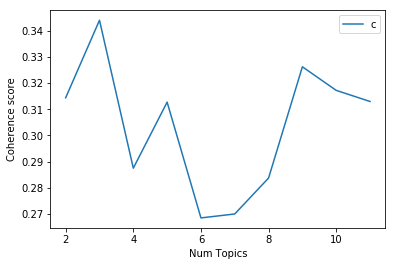

In [23]:
# Show graph
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.111*"pick" + 0.096*"easy" + 0.090*"app" + 0.078*"drop" + 0.071*"love" + '
  '0.049*"fold" + 0.047*"super" + 0.044*"friendly" + 0.032*"convenient" + '
  '0.023*"highly_recommend"'),
 (1,
  '0.141*"laundry" + 0.060*"make" + 0.044*"work" + 0.041*"laundromat" + '
  '0.039*"schedule" + 0.032*"hour" + 0.024*"late" + 0.024*"nyc" + '
  '0.019*"worth" + 0.019*"life"'),
 (2,
  '0.082*"wash" + 0.076*"fold" + 0.076*"dry" + 0.070*"bag" + 0.038*"valet" + '
  '0.029*"option" + 0.026*"time" + 0.025*"hang_dry" + 0.021*"free" + '
  '0.019*"shirt"'),
 (3,
  '0.137*"service" + 0.058*"customer" + 0.037*"experience" + 0.037*"item" + '
  '0.034*"lose" + 0.033*"year" + 0.022*"pay" + 0.020*"problem" + '
  '0.020*"expensive" + 0.019*"team"'),
 (4,
  '0.208*"cleanly" + 0.129*"laundry" + 0.045*"recommend" + 0.039*"day" + '
  '0.038*"send" + 0.020*"door" + 0.016*"perfect" + 0.016*"text" + 0.015*"move" '
  '+ 0.014*"care"'),
 (5,
  '0.162*"clothe" + 0.107*"clean" + 0.104*"back" + 0.060*"smell" + '
  '0.04

In [40]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(positive['review'].values)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [41]:
#positive['review'].values

In [42]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=positive)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.2076,"laundry, make, work, laundromat, schedule, hou...",I used this app for the first time last Friday...
1,1,5.0,0.1610,"clothe, clean, back, smell, price, give, amazi...",I've used them for a few years now. We have ha...
2,2,1.0,0.2540,"laundry, make, work, laundromat, schedule, hou...","This app is great. I can schedule easily, if i..."
3,3,7.0,0.1403,"time, delivery, good, pickup, thing, order, is...",I've never had an issue with this company. I w...
4,4,3.0,0.1884,"service, customer, experience, item, lose, yea...",I've had good experiences with pickup and drop...
5,5,7.0,0.1326,"time, delivery, good, pickup, thing, order, is...",They fulfilled every aspect of the services ad...
6,6,7.0,0.2056,"time, delivery, good, pickup, thing, order, is...",I've used Cleanly for more than a year and had...
7,7,1.0,0.1574,"laundry, make, work, laundromat, schedule, hou...",Cleanly is great - it is so much easier to hav...
8,8,1.0,0.2169,"laundry, make, work, laundromat, schedule, hou...",App has a great UI and is very straight forwar...
9,9,0.0,0.1373,"pick, easy, app, drop, love, fold, super, frie...",I will probably never do my own laundry again!...


Topic: 0.0


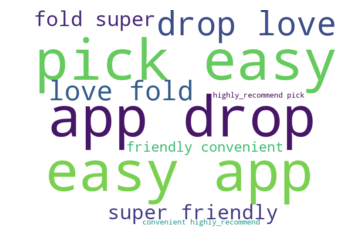

Topic: 1.0


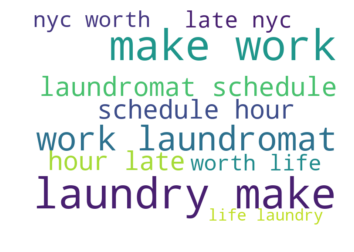

Topic: 2.0


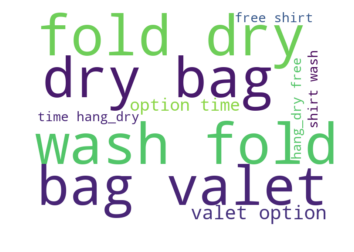

Topic: 3.0


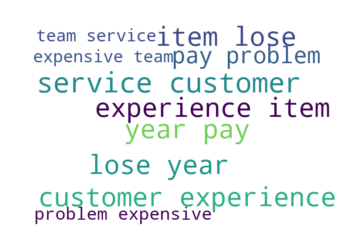

Topic: 4.0


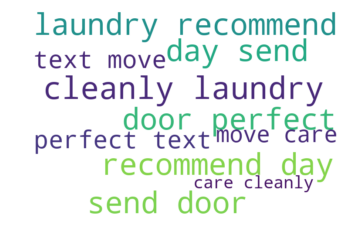

Topic: 5.0


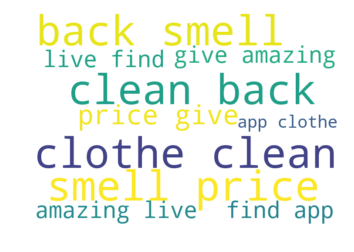

Topic: 6.0


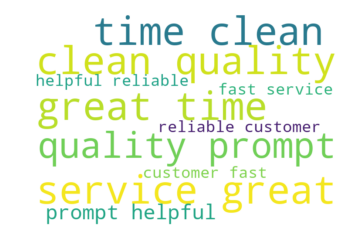

Topic: 7.0


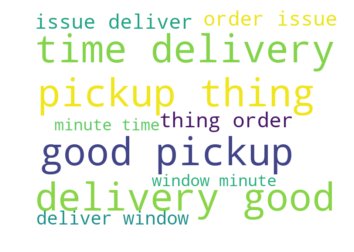

Topic: 8.0


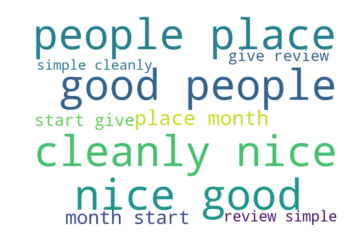

In [60]:
#Topic keys
from wordcloud import WordCloud
import matplotlib.pyplot as plt
Topic_keys = pd.DataFrame(df_dominant_topic['Keywords'].groupby(df_dominant_topic['Dominant_Topic']).apply(list))

Topic_keys['Topic'] = Topic_keys.index
Topic_keys.index=range(len(Topic_keys.index))

for i in range(len(Topic_keys)):
    
    text=' '.join(Topic_keys['Keywords'][i]) 

    wordcloud = WordCloud(width=700, height=500, margin=0, background_color="white").generate(text)

    print('Topic: %s' % (Topic_keys['Topic'][i]))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
  

Text(0.5,0,'Topic_Proportion')

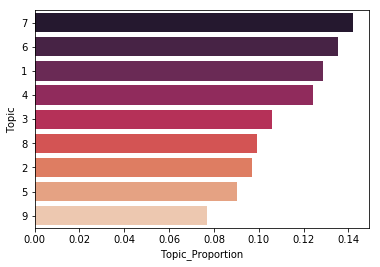

In [58]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Show
topic_prop = pd.DataFrame(topic_contribution)
topic_prop['Topic'] = topic_prop.index
topic_prop['Topic'] = topic_prop['Topic']+1
topic_prop.index = range(len(topic_prop.index))
topic_prop = topic_prop.rename(columns={'Dominant_Topic':'Topic_Proportion'})

#topic_prop.style.format({'Topic_Proportion': "{:.2%}"})
import seaborn as sns
ax = sns.barplot(x='Topic_Proportion', y='Topic', data=topic_prop,  orient = 'h',palette="rocket", order =topic_prop['Topic'] )
ax.set_xlabel('Topic_Proportion')

In [54]:
from gensim.models.ldamodel import LdaModel
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [55]:
lda_model = convertldaGenToldaMallet(optimal_model)

In [57]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,sort_topics=False)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.077819  0.335300       1        1  10.679885
1      0.239161 -0.050729       2        1  11.576254
2     -0.095236  0.126334       3        1  11.546801
3     -0.195711 -0.241118       4        1  10.955523
4      0.315900 -0.089108       5        1  11.402336
5     -0.013211  0.196866       6        1  10.984014
6     -0.259251 -0.163414       7        1  10.149517
7     -0.102105 -0.044562       8        1  10.997539
8      0.188272 -0.069571       9        1  11.708138, topic_info=     Category        Freq       Term       Total  loglift  logprob
52    Default  633.000000    service  633.000000  30.0000  30.0000
149   Default  605.000000    cleanly  605.000000  29.0000  29.0000
31    Default  525.000000    laundry  525.000000  28.0000  28.0000
74    Default  299.000000     clothe  299.000000  27.0000  27.0000
59    Default  520.000000       time  520.000000  26.0000  26.0000
24    Default  263.000000      great  263.000000  25.0000  25.0000
43    Default  199.000000       pick  199.000000  24.0000  24.0000
76    Default  199.000000   delivery  199.000000  23.0000  23.0000
7     Default  251.000000      clean  251.000000  22.0000  22.0000
3     Default  196.000000       back  196.000000  21.0000  21.0000
114   Default  181.000000       easy  181.000000  20.0000  20.0000
20    Default  234.000000       fold  234.000000  19.0000  19.0000
2     Default  202.000000        app  202.000000  18.0000  18.0000
23    Default  221.000000       good  221.000000  17.0000  17.0000
243   Default  159.000000       wash  159.000000  16.0000  16.0000
78    Default  146.000000        dry  146.000000  15.0000  15.0000
111   Default  147.000000       drop  147.000000  14.0000  14.0000
4     Default  135.000000        bag  135.000000  13.0000  13.0000
298   Default  128.000000       love  128.000000  12.0000  12.0000
126   Default  117.000000       make  117.000000  11.0000  11.0000
289   Default  110.000000      smell  110.000000  10.0000  10.0000
153   Default  135.000000   customer  135.000000   9.0000   9.0000
189   Default  102.000000     pickup  102.000000   8.0000   8.0000
277   Default   92.000000      thing   92.000000   7.0000   7.0000
38    Default   90.000000       nice   90.000000   6.0000   6.0000
58    Default   84.000000      super   84.000000   5.0000   5.0000
145   Default   85.000000       work   85.000000   4.0000   4.0000
192   Default   89.000000  recommend   89.000000   3.0000   3.0000
157   Default   81.000000      issue   81.000000   2.0000   2.0000
45    Default   80.000000      price   80.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
46     Topic9   21.695005    pricing   21.695005   2.1449  -4.5095
579    Topic9   21.695005      cheap   21.695005   2.1449  -4.5095
25     Topic9   21.695005       hand   21.695005   2.1449  -4.5095
215    Topic9   20.339066        end   20.339066   2.1449  -4.5740
233    Topic9   18.983130       plan   18.983130   2.1449  -4.6430
339    Topic9   17.627192      close   17.627192   2.1449  -4.7171
770    Topic9   17.627192      extra   17.627192   2.1449  -4.7171
782    Topic9   17.627192       huge   17.627192   2.1449  -4.7171
437    Topic9   16.271254        bad   16.271254   2.1449  -4.7972
245    Topic9   16.271254      wrong   16.271254   2.1449  -4.7972
310    Topic9   14.915317    address   14.915317   2.1449  -4.8842
481    Topic9   14.915317   organize   14.915317   2.1449  -4.8842
131    Topic9   13.559379       open   13.559379   2.1449  -4.9795
702    Topic9   13.559379      trust   13.559379   2.1449  -4.9795
120    Topic9   12.203441       hate   12.203441   2.1449  -5.0848
789    Topic9   12.203441       real   12.203441   2.1449  -5.0848
190    Topic9   12.203441      reach   12.203441   2.1449  -5.0848
424    Topic9   10.847503   business   10.847503   2.1449  -5.2026
91     Topic9

In [59]:
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.save_html(p, 'lda_positive.html')

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [52]:
df_topic_sents_keywords['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'].astype(int)
df_topic_sents_keywords[df_topic_sents_keywords['Dominant_Topic']==1]
df_topic_sents_keywords['Topic_Keywords'][274]

'laundry, make, work, laundromat, schedule, hour, late, nyc, worth, life'

In [53]:
df_topic_sents_keywords[0][274]

"I've been using this service for nearly a year and it's been great, extremely convenient for weeks where I simply don't have time to do laundry. Clothes always come back feeling clean and fresh, and being able to track pickup and delivery with a face and name makes me feel even more comfortable with the service."

In [61]:
df_dominant_topic[['Dominant_Topic', 'Topic_Perc_Contrib', 'Text']].to_csv('yelp_positive_reviews.csv', index = False)

In [62]:
df_dominant_topic[['Dominant_Topic', 'Topic_Perc_Contrib', 'Text']].shape

(443, 3)